---
# Hamiltonian simulation of a one-mode bosonic system
---
In this notebook, we simulate the dynamics of a simple zero-dimensional, i.e. one-mode bosonic system, the anharmonic oscillator, on a quantum computer. 

In contrast to the fermionic one, the bosonic Fock space is infinite-dimensional and must be truncated to a finite number $N$ of basis states $|0\rangle, |1\rangle, \dots, |N-1\rangle$. There are numerous possibilities to encode these states in binary qubit representations, e.g by standard binary numbers or a one-hot encoding. Here we follow a proposal from [Sawaya et al.](https://www.nature.com/articles/s41534-020-0278-0) and employ a [Gray code](https://en.wikipedia.org/wiki/Gray_code) binary representation. Since in the Gray code, subsequent binary strings always differ in only one bit, this representation is particularly convenient for the translation of tridiagonal matrices like the bosonic annihilation and creation operators to quantum gates.


## Preparations

In [15]:
import qiskit as qs
import numpy as np

In [2]:
# Translate the exponential of a string of Pauli matrices into a quantum circuit 
def pauli_exp(pauli_string, alpha):
    n = len(pauli_string)
    qc = qs.QuantumCircuit(n)

    for i, pauli in enumerate(pauli_string):
        if pauli == "X":
            qc.ry(-np.pi/2, i)
        elif pauli == "Y":
            qc.rx(np.pi/2, i)
        elif pauli == "Z":
            ...
        else:
            raise Exception("Pauli string must be X, Y or Z")

    for i in range(n-1):
        qc.cx(i, i+1)
    qc.rz(2*alpha, n-1)
    for i in reversed(range(n-1)):
        qc.cx(i, i+1)

    for i, pauli in enumerate(pauli_string):
        if pauli == "X":
            qc.ry(np.pi/2, i)
        elif pauli == "Y":
            qc.rx(-np.pi/2, i)
        
    return qc

#Given an arbitrary binary code, i.e. a map from the natural numbers to the binary strings,
#convert an input matrix to a sum of Pauli strings
def convert_matrix_to_pauli(M, binary_code):
    pauli_strings = []
    n, m = np.shape(M)
    for i in range(n):
        for j in range(m):
            if np.abs(M[i][j])>1.e-10:
                _pauli_strings = []
                code1 = binary_code[i]
                code2 = binary_code[j]
                for c1, c2 in zip(code1, code2):
                    if c1==0 and c2==0:
                        if _pauli_strings==[]:
                            _pauli_strings = [{'factor': 0.5*M[i][j], 'matrices': 'I'},
                                              {'factor': 0.5*M[i][j], 'matrices': 'Z'}]
                        else:
                            _pauli_strings = [{'factor': 0.5*p['factor'], 'matrices': p['matrices']+'I'} for p in _pauli_strings]\
                                            +[{'factor': 0.5*p['factor'], 'matrices': p['matrices']+'Z'} for p in _pauli_strings]
                    elif c1==0 and c2==1:
                        if _pauli_strings==[]:
                            _pauli_strings = [{'factor': 0.5*M[i][j], 'matrices': 'X'},
                                              {'factor': 0.5j*M[i][j], 'matrices': 'Y'}]
                        else:
                            _pauli_strings = [{'factor': 0.5*p['factor'], 'matrices': p['matrices']+'X'} for p in _pauli_strings]\
                                            +[{'factor': 0.5j*p['factor'], 'matrices': p['matrices']+'Y'} for p in _pauli_strings]
                    elif c1==1 and c2==0:
                        if _pauli_strings==[]:
                            _pauli_strings = [{'factor': 0.5*M[i][j], 'matrices': 'X'},
                                              {'factor': -0.5j*M[i][j], 'matrices': 'Y'}]
                        else:
                            _pauli_strings = [{'factor': 0.5*p['factor'], 'matrices': p['matrices']+'X'} for p in _pauli_strings]\
                                            +[{'factor': -0.5j*p['factor'], 'matrices': p['matrices']+'Y'} for p in _pauli_strings]
                    elif c1==1 and c2==1:
                        if _pauli_strings==[]:
                            _pauli_strings = [{'factor': 0.5*M[i][j], 'matrices': 'I'},
                                              {'factor': -0.5*M[i][j], 'matrices': 'Z'}]
                        else:
                            _pauli_strings = [{'factor': 0.5*p['factor'], 'matrices': p['matrices']+'I'} for p in _pauli_strings]\
                                            +[{'factor': -0.5*p['factor'], 'matrices': p['matrices']+'Z'} for p in _pauli_strings]

                pauli_strings += _pauli_strings

    unique_strings = list(dict.fromkeys([p['matrices'] for p in pauli_strings]))
    _pauli_strings_summed = []
    for unique_string in unique_strings:
        _pauli_strings_summed.append({
                                    'factor': sum([p['factor'] for p in pauli_strings if p['matrices']==unique_string]),
                                    'matrices': unique_string
                                    })

    pauli_strings_summed = [pss for pss in _pauli_strings_summed if abs(pss['factor'])>1.e-10]
            
    return pauli_strings_summed

#Perform a Trotter-Suzuki decomposition of an exponential of an operator
def get_U_circuit(pauli_strings, TS_steps, T, N_qubits):
    exponentials = []
    for ps in pauli_strings:
        affected_qubits = [i for i in range(len(ps['matrices'])) if ps['matrices'][i]!="I"]
        reduced_string = "".join([x for x in ps['matrices'] if x!="I"])
        if len(reduced_string)>0:
            exponentials.append(
                {
                    'qubits': affected_qubits,
                    'circuit': pauli_exp(reduced_string, np.real(T/TS_steps*ps['factor']))
                }
            )
    
    TS_step = qs.QuantumCircuit(N_qubit)
    for exponential in exponentials:
        TS_step = TS_step.compose(exponential['circuit'], exponential['qubits'])

    U = qs.QuantumCircuit(N_qubit)
    for i in range(TS_steps):
        U = U.compose(TS_step, list(range(N_qubit)))

    return U

#Compute the Gray code
def gray_code(n):
    code = []
    for i in range(n):
        temp = []
        block1 = (2**i)*[0]+(2**i)*[1]
        block2 = (2**i)*[1]+(2**i)*[0]
        for j in range(2**(n-i-1)):
            if j%2==0:
                temp += block1
            else:
                temp += block2
        code.append(temp)

    return np.transpose(np.asarray(code)).tolist()

In [16]:
#Bosonic creation and annihilation operators

def a(N):
    return np.diag(np.sqrt(np.arange(1,N)),k=1).astype(complex)
            
def a_dagger(N):
    return np.diag(np.sqrt(np.arange(1,N)),k=-1).astype(complex)

## Anharmonic oscillator

We want to simulate the Hamiltonian of a harmonic oscillator but with a non-linear coupling of strength $\lambda$:
\\[
H=a^\dagger a+\frac{\lambda}{4}\left(a^\dagger+a\right)^4
\\]
As initial state, we take a coherent state $|i\alpha\rangle$, $\alpha\in\mathbb{R}$, centered around $x=0$ and with initial momentum $p=\sqrt{2}\alpha$. The latter can be prepared by acting with the displacement operator on to the ground state:
\\[
|i\alpha\rangle = \exp\left(i\alpha\left[a^\dagger+a\right]\right)|0\rangle
\\]
As an observable, we take the position operator $(a^\dagger+a)/\sqrt{2}$. Thanks to the Gray code representation, it is rather straightforward to evaluate. We have
\\[
\frac{1}{\sqrt{2}}\langle \psi | (a^\dagger+a) | \psi \rangle = \frac{1}{\sqrt{2}}\sum_{nm} c_n^*c_m \langle n | (a^\dagger+a) | m \rangle = \sum_n \sqrt{n+1} \left[c_{n+1}^*c_n+c_{n+1}c_n^*\right]
\\]
In the Gray code representation, the states $n$ and $n+1$ differ only by one qubit, so we can obtain $c_{n+1}^*c_n+c_{n+1}c_n^*$ by applying a Hadamard gate to this one qubit and then computing the difference in the probabilities of $|0\rangle$ and $|1\rangle$ measurements in this qubit:
\\[
\frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix} \begin{pmatrix}c_0 \\ c_1\end{pmatrix} = \frac{1}{\sqrt{2}} \begin{pmatrix}c_0+c_1 \\ c_0-c_1\end{pmatrix}
\\]
\\[
\frac{1}{2}|c_0+c_1|^2-\frac{1}{2}|c_0-c_1|^2=c_0^*c_1+c_0c_1^*
\\]

Define physical and numerical parameters, as well as the Hamiltonian:

In [4]:
#physical parameters
times = np.arange(0,5,0.1)
lambd = 0.1
alpha = 1

#numerical parameters
N_qubit = 5
N = 2**N_qubit
TS_dt = 0.02
shots = 4096


H = a_dagger(N)@a(N)+lambd/4*np.linalg.matrix_power(a_dagger(N)+a(N),4)

In [5]:
hardware = True

from qiskit.primitives import StatevectorSampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

if hardware:
    fake_manila = FakeManilaV2()
    pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
    options = {"simulator": {"seed_simulator": 42}}
    sampler = Sampler(mode=fake_manila, options=options)
else:
    sampler = StatevectorSampler()



Construct circuits for a range of evolution times, and with each qubit subjected to a Hadamard gate before measurement once:

In [7]:
#displacement operator
pauli_strings_D = convert_matrix_to_pauli(a_dagger(N)+a(N), gray_code(N_qubit))
U_D = get_U_circuit(pauli_strings_D, 50, -alpha, N_qubit)


counts_all = []
gray = gray_code(N_qubit)

for T in times:
    counts_per_T = []
    for n in range(N_qubit):
        pauli_strings_H = convert_matrix_to_pauli(H, gray_code(N_qubit))
        U_H = get_U_circuit(pauli_strings_H, max(1,int(T/TS_dt)), T, N_qubit)
        
        qc = qs.QuantumCircuit(N_qubit)
        qc = qc.compose(U_D, list(range(N_qubit)))
        qc = qc.compose(U_H, list(range(N_qubit)))
    
        qc.h(n)
        
        qc.measure_all()

        if hardware:
            job = sampler.run([pm.run(qc)], shots=shots)
        else:
            job = sampler.run([qc], shots=shots)
        result = job.result()[0].data.meas.get_counts()

        counts = np.zeros(N)
        for i in range(N):
            gray_string = "".join(list(reversed([str(x) for x in gray[i]]))) 
            counts[i] = result.get(gray_string,0)
        counts_per_T.append(counts)
    
    counts_all.append(counts_per_T)

prob = np.asarray(counts_all)/shots

Compute the expectation value of the position space operator as described above:

In [11]:
gray = gray_code(N_qubit)
xt = np.array([])
for i in range(len(times)):
    x = 0
    for n in range(N-1):
        gray_diff = np.asarray(gray[n+1])-np.asarray(gray[n])
        differing_qubit = np.where(gray_diff!=0)[0][0]
        if gray_diff[differing_qubit]==1:
            overlap = prob[i][differing_qubit][n]-prob[i][differing_qubit][n+1]
        elif gray_diff[differing_qubit]==-1:
            overlap = prob[i][differing_qubit][n+1]-prob[i][differing_qubit][n]
        else:
            raise Exception("Invalid Gray code")
        x += np.sqrt(n+1)*overlap/2**0.5
    xt = np.append(xt, x)
    

Time evolution of the expectation value of the position operator:

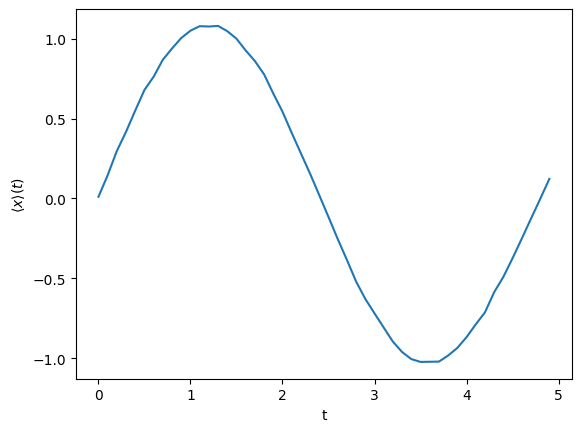

In [12]:
import matplotlib.pyplot as plt

plt.plot(times, xt)
plt.xlabel("t")
plt.ylabel(r"$\langle x \rangle(t)$")
plt.show()

For comparison, we compute the dynamics of the anharmonic oscillator without the use of a quantum computer:

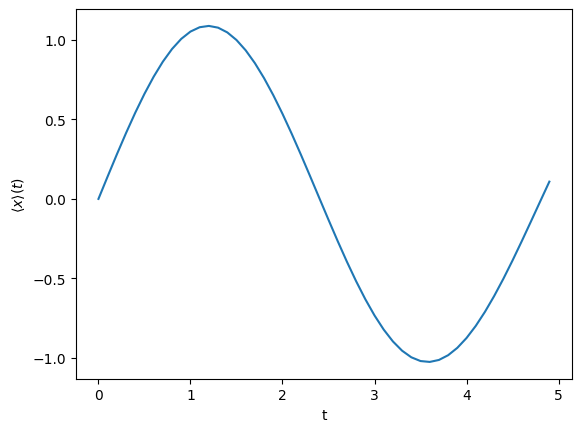

In [13]:
from scipy.linalg import expm
psi0 = np.zeros(N, dtype=complex)
psi0[0] = 1.
psi0 = expm(1j*(a_dagger(N)+a(N)))@psi0

xt = np.array([])
for T in times:
    psit = expm(-1j*T*H)@psi0
    x = np.real(np.transpose(np.conj(psit))@(a_dagger(N)+a(N))@psit/2**0.5)
    xt = np.append(xt, x)

plt.plot(times, xt)
plt.xlabel("t")
plt.ylabel(r"$\langle x \rangle(t)$")
plt.show()